In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [16]:
# ===============================
# Generate a Multi-Class Dataset
# ===============================

# Set a random seed so that results are the same every time
np.random.seed(42)

# -------------------------------
# Dataset parameters
# -------------------------------
n_samples = 1000   # Total number of data points we want
n_features = 2     # Each data point has 2 features
n_classes = 5      # We want 5 different classes

# -------------------------------
# Create the dataset
# -------------------------------
# make_blobs helps us create clusters of points
# Each cluster will represent a class
# cluster_std controls how spread out the points are in each cluster
X, y = make_blobs(n_samples=n_samples,
                  centers=n_classes,
                  n_features=n_features,
                  random_state=42,
                  cluster_std=1.5)

# -------------------------------
# One-hot encode the labels
# -------------------------------
# Neural networks work better with one-hot encoded labels for multi-class problems
# Example:
# Class 0 → [1, 0, 0, 0, 0]
# Class 1 → [0, 1, 0, 0, 0]
# Class 4 → [0, 0, 0, 0, 1]
ohe = OneHotEncoder(sparse_output=False)
Y = ohe.fit_transform(y.reshape(-1, 1))

# -------------------------------
# Check the shapes of the dataset
# -------------------------------
print(f"Input features (X) shape: {X.shape}")  # Should be (1000, 2)
print(f"Output labels (Y) shape: {Y.shape}")  # Should be (1000, 5)
print(f"Number of classes: {n_classes}")


Input features (X) shape: (1000, 2)
Output labels (Y) shape: (1000, 5)
Number of classes: 5


In [17]:
# ===============================
# Define a Three-Hidden-Layer Neural Network
# ===============================

class NeuralNetwork:
    def __init__(self, n_features, n_classes):
        # -------------------------------
        # Layer sizes
        # -------------------------------
        inputLayerNeurons = n_features       # Number of input features
        hiddenLayerNeurons = 10              # Number of neurons in each hidden layer
        outLayerNeurons = n_classes          # Number of output neurons (one per class)

        # Learning rate for weight updates
        self.learning_rate = 0.2

        # -------------------------------
        # Initialize weights randomly
        # -------------------------------
        # W_H1I: weights from input to first hidden layer
        # W_H2H1: weights from first hidden layer to second hidden layer
        # W_H3H2: weights from second hidden layer to third hidden layer
        # W_OH3: weights from third hidden layer to output layer
        self.W_H1I = np.random.randn(inputLayerNeurons, hiddenLayerNeurons)
        self.W_H2H1 = np.random.randn(hiddenLayerNeurons, hiddenLayerNeurons)
        self.W_H3H2 = np.random.randn(hiddenLayerNeurons, hiddenLayerNeurons)
        self.W_OH3 = np.random.randn(hiddenLayerNeurons, outLayerNeurons)

    # -------------------------------
    # Activation functions
    # -------------------------------
    def sigmoid(self, x, der=False):
        """
        Sigmoid activation function:
        σ(x) = 1 / (1 + exp(-x))
        derivative for backpropagation: σ'(x) = σ(x) * (1 - σ(x))
        """
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Softmax activation for output layer:
        S_j = exp(z_j) / sum_k(exp(z_k))
        Converts raw scores into probabilities for multi-class classification
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability trick
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # -------------------------------
    # Forward pass
    # -------------------------------
    def feedForward(self, X):
        # Input → Hidden Layer 1
        self.H1_out = self.sigmoid(np.dot(X, self.W_H1I))
        # Hidden Layer 1 → Hidden Layer 2
        self.H2_out = self.sigmoid(np.dot(self.H1_out, self.W_H2H1))
        # Hidden Layer 2 → Hidden Layer 3
        self.H3_out = self.sigmoid(np.dot(self.H2_out, self.W_H3H2))
        # Hidden Layer 3 → Output Layer
        output = np.dot(self.H3_out, self.W_OH3)
        return self.softmax(output)

    # -------------------------------
    # Backpropagation
    # -------------------------------
    def backPropagation(self, X, Y, pred):
        """
        Update weights using the difference between predicted and true labels
        δ_output = (pred - Y) / N
        δ_hidden = (error dot next_layer_weights.T) * sigmoid_derivative
        W = W - learning_rate * (hidden_output.T dot δ_next)
        """
        # Output layer error
        output_delta = (pred - Y) / X.shape[0]
        # Update output weights
        self.W_OH3 -= self.learning_rate * self.H3_out.T.dot(output_delta)

        # Hidden Layer 3 error and update
        H3_error = output_delta.dot(self.W_OH3.T)
        H3_delta = H3_error * self.sigmoid(self.H3_out, der=True)
        self.W_H3H2 -= self.learning_rate * self.H2_out.T.dot(H3_delta)

        # Hidden Layer 2 error and update
        H2_error = H3_delta.dot(self.W_H3H2.T)
        H2_delta = H2_error * self.sigmoid(self.H2_out, der=True)
        self.W_H2H1 -= self.learning_rate * self.H1_out.T.dot(H2_delta)

        # Hidden Layer 1 error and update
        H1_error = H2_delta.dot(self.W_H2H1.T)
        H1_delta = H1_error * self.sigmoid(self.H1_out, der=True)
        self.W_H1I -= self.learning_rate * X.T.dot(H1_delta)

    # -------------------------------
    # Train the network for one step
    # -------------------------------
    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

    # -------------------------------
    # Predict class labels
    # -------------------------------
    def predict(self, X):
        # Returns class index with highest probability
        return np.argmax(self.feedForward(X), axis=1)


In [10]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=y)


In [18]:
# Initialize the neural network with the specified number of features and classes
NN = NeuralNetwork(n_features=n_features, n_classes=n_classes)

# Set the number of training iterations (epochs)
epochs = 10000

# Train the network for the given number of epochs
for i in range(epochs):
    # Perform forward pass and backpropagation to update weights
    NN.train(X_train, Y_train)


In [19]:
# ===============================
# Make predictions on the test data
# ===============================

# Predict class labels for the test set
Y_pred_labels = NN.predict(X_test)

# Convert one-hot encoded test labels back to class indices
Y_test_labels = np.argmax(Y_test, axis=1)

# -------------------------------
# Calculate evaluation metrics
# -------------------------------

# Overall accuracy of the model
accuracy = accuracy_score(Y_test_labels, Y_pred_labels)

# Detailed classification report including precision, recall, and F1-score
report = classification_report(Y_test_labels, Y_pred_labels, digits=4)

# -------------------------------
# Display results
# -------------------------------
print("--- Model Evaluation on Testing Data ---")
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report (Precision, Recall, F1-Score):")
print(report)



--- Model Evaluation on Testing Data ---
Overall Accuracy: 0.9450

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        40
           1     0.9189    0.8500    0.8831        40
           2     1.0000    1.0000    1.0000        40
           3     0.9756    1.0000    0.9877        40
           4     0.8409    0.9250    0.8810        40

    accuracy                         0.9450       200
   macro avg     0.9471    0.9450    0.9452       200
weighted avg     0.9471    0.9450    0.9452       200



<Figure size 800x800 with 0 Axes>

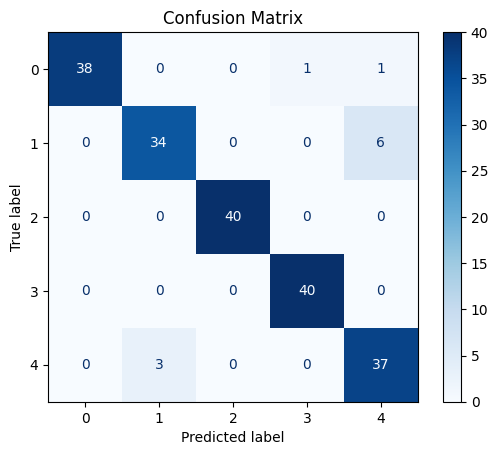

In [20]:
# ===============================
# Confusion Matrix Visualization
# ===============================

# Compute confusion matrix
cm = confusion_matrix(Y_test_labels, Y_pred_labels)

# Create a display object for plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ohe.categories_[0])

# Set figure size
plt.figure(figsize=(8, 8))

# Plot the confusion matrix with a blue color map
disp.plot(cmap=plt.cm.Blues)

# Add a title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


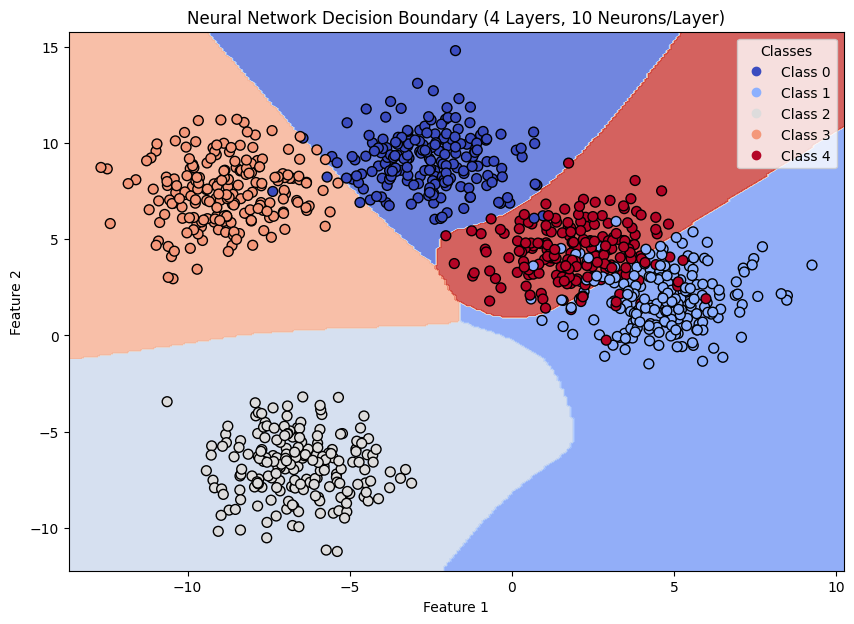

In [21]:
# ===============================
# Visualize Neural Network Decision Boundary
# ===============================

h = 0.1  # step size for the mesh grid

# Define the range for the mesh grid based on feature values
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Create a mesh grid to evaluate the model at every point
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the class for each point in the mesh grid
Z = NN.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)  # reshape predictions to match grid shape

# Plot the decision boundary
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

# Overlay the original data points
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)

# Add plot title and axis labels
plt.title("Neural Network Decision Boundary (4 Layers, 10 Neurons/Layer)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Add legend for the classes
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Class {i}' for i in range(n_classes)], title="Classes")

# Display the plot
plt.show()


In [23]:
# Multi-class Classification Implementation and Challenges


- I modified the original code to handle **five distinct classes** instead of a single output.
- The output layer now has **5 neurons**, one for each class.
- The activation function of the output layer was updated to **Softmax** to convert raw scores into probabilities:

  \[
  \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}
  \]

  This ensures that:
  - All predicted probabilities are between 0 and 1.
  - The sum of probabilities across all classes equals 1.

- The backpropagation algorithm was adapted for **multi-class cross-entropy loss**.
  The error at the output layer is computed as:



In [ ]:
# Challenges Faced and Solutions

- **Challenge 1:** The original backpropagation assumed a binary output, so multi-class updates were incorrect.
  **Solution:** I modified the delta calculation and weight updates to handle Softmax outputs with one-hot labels.

- **Challenge 2:** The network did not converge properly with random weight initialization or wrong learning rate.
  **Solution:** I used `np.random.randn` for weight initialization and set `learning_rate = 0.2`.

- **Challenge 3:** I needed proper evaluation metrics to check the model's performance.
  **Solution:** I used `sklearn.metrics` to calculate **accuracy, precision, recall, and F1-score** for all classes.

- **Challenge 4:** Visualizing decision boundaries for 5 classes in 2D was tricky.
  **Solution:** I created a mesh grid using `np.meshgrid` and plotted predictions with `plt.contourf`.
